# Initialization

In [1]:
%%time

%matplotlib inline
import os
import sys
import datetime
import re
import collections

import json
import pickle
import urllib
import pandas as pd
import numpy as np

from collections import OrderedDict
from gspread import WorksheetNotFound
from bs4 import BeautifulSoup
from oauth2client.service_account import ServiceAccountCredentials

pd.set_option("display.max_columns", 100)

DATETIME_STRING_FORMAT = '%Y-%m-%d %H:%M:%S'

# Tables to retrieve for each player, by table html ids
TABLE_IDS = [
    'per_game',
    'totals',
    'per_minute',  # per 36 minutes
    'per_poss',  # per 100 possessions
    'advanced',  # advanced
    'playoffs_per_game',
    'playoffs_totals',
    'playoffs_per_minute',  # playoffs per 36 minutes
    'playoffs_per_poss',  # playoffs per 100 possessions
    'playoffs_advanced',
    'all_star',
    'all_college_stats',
    'all_salaries',
]

print('Current TABLE_IDS length: ', len(TABLE_IDS))

Current TABLE_IDS length:  13
CPU times: user 925 ms, sys: 366 ms, total: 1.29 s
Wall time: 1.62 s


In [2]:
%%time

test = {
    'words':
    """
        Lorem ipsum dolor sit amet, consectetur adipiscing 
        elit. Mauris adipiscing adipiscing placerat. 
        Vestibulum augue augue, 
        pellentesque quis sollicitudin id, adipiscing.
        """,
    'list':
    list(range(10000)),
    'dict':
    dict((str(i), 'a') for i in range(10000)),
    'int':
    100,
    'float':
    100.123456
}


def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


def get_file_size(filename):
    statinfo = os.stat(filename)
    return sizeof_fmt(statinfo.st_size)


def save_pickle(item, filename):
    with open(filename, 'wb') as file:
        pickle.dump(item, file)
    print('\n'
          'SAVED  > ', filename, ' | ',
          get_file_size(filename), ' | ', 'length: ', len(item), '\n')
    return True


def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
        print('\n'
              'LOADED > ', filename, ' | ',
              get_file_size(filename), ' | ', 'length: ', len(obj), '\n')
        return obj


save_pickle(test, 'test.pickle')

len(load_pickle('test.pickle'))


SAVED  >  test.pickle  |  183.8 KiB  |  length:  5 


LOADED >  test.pickle  |  183.8 KiB  |  length:  5 

CPU times: user 14.5 ms, sys: 3.8 ms, total: 18.3 ms
Wall time: 20.5 ms


### Load Data

In [3]:
# all_players_stats is a dictionary
# all_players_stats{"table_name": dataframe}, dataframe has player_name as indices
# all_players_stats['advanced'].loc['yao ming'] would return Yao Ming's advanced stats

all_players_stats = load_pickle('all_players_dfs.pickle')


LOADED >  all_players_dfs.pickle  |  57.4 MiB  |  length:  15 



In [4]:
all_players_stats['totals'].loc['yao ming']

,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Pos,STL,TOV,TRB,Tm,eFG%
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-03,400.0,0.498,803.0,1.0,0.5,2.0,137.0,22.0,147.0,479.0,401.0,0.498,805.0,301.0,0.811,371.0,82.0,72.0,NBA,2382.0,196.0,230.0,1104.0,C,31.0,173.0,675.0,HOU,0.499
2003-04,535.0,0.523,1023.0,0.0,0.0,2.0,122.0,23.0,156.0,538.0,535.0,0.522,1025.0,361.0,0.809,446.0,82.0,82.0,NBA,2692.0,197.0,273.0,1431.0,C,22.0,204.0,735.0,HOU,0.522
2004-05,538.0,0.552,975.0,0.0,NaN,0.0,61.0,24.0,160.0,461.0,538.0,0.552,975.0,389.0,0.783,497.0,80.0,80.0,NBA,2447.0,208.0,298.0,1465.0,C,34.0,196.0,669.0,HOU,0.552
2005-06,467.0,0.519,899.0,0.0,0.0,1.0,85.0,25.0,94.0,433.0,467.0,0.519,900.0,337.0,0.853,395.0,57.0,57.0,NBA,1949.0,148.0,195.0,1271.0,C,30.0,147.0,581.0,HOU,0.519
2006-07,423.0,0.518,817.0,0.0,0.0,2.0,94.0,26.0,94.0,351.0,423.0,0.516,819.0,356.0,0.862,413.0,48.0,48.0,NBA,1624.0,101.0,159.0,1202.0,C,17.0,167.0,452.0,HOU,0.516
2007-08,432.0,0.508,850.0,0.0,0.0,2.0,129.0,27.0,111.0,422.0,432.0,0.507,852.0,345.0,0.850,406.0,55.0,55.0,NBA,2044.0,172.0,171.0,1209.0,C,25.0,183.0,594.0,HOU,0.507
2008-09,565.0,0.548,1031.0,1.0,1.0,1.0,137.0,28.0,150.0,557.0,566.0,0.548,1032.0,381.0,0.866,440.0,77.0,77.0,NBA,2589.0,204.0,257.0,1514.0,C,30.0,234.0,761.0,HOU,0.549
2010-11,18.0,0.486,37.0,0.0,NaN,0.0,4.0,30.0,8.0,20.0,18.0,0.486,37.0,15.0,0.938,16.0,5.0,5.0,NBA,91.0,7.0,13.0,51.0,C,0.0,7.0,27.0,HOU,0.486
Career,3378.0,0.525,6435.0,2.0,0.2,10.0,769.0,NaN,920.0,3261.0,3380.0,0.524,6445.0,2485.0,0.833,2984.0,486.0,476.0,NBA,15818.0,1233.0,1596.0,9247.0,NaN,189.0,1311.0,4494.0,NaN,0.525


In [5]:
# all_players_attributes is an ordered dictionary
# all_players_attributes{"player_name": {'attribute_name': attribute_value}}, 
# all_players_attributes['yao ming']['birth_date'] would return Yao Ming's birth-date

all_players_attributes = load_pickle('all_players_attributes.pickle')

print(all_players_attributes['kobe bryant'].keys())


LOADED >  all_players_attributes.pickle  |  5.9 MiB  |  length:  3997 

dict_keys(['nicknames', 'chinese_name', 'draft', 'transactions', 'height', 'position', 'missing_attributes', 'birth_date', 'relatives', 'nba_debut', 'honors', 'birth_place', 'numbers', 'twitter', 'shooting_hand', 'high_school', 'url', 'weight'])


In [ ]:
all_players_attributes['kobe bryant']['missing_attributes']

In [ ]:
all_players_stats['advanced'].loc[(slice(None), '2002-03'), :]

In [ ]:
all_players_stats['advanced'].xs('2009-10', level=1, drop_level=False)['WS'].plot('hist')

In [ ]:
all_players_career_winshare = all_players_stats['advanced'].xs('Career', level=1, drop_level=True)['WS']

In [ ]:
all_players_career_winshare[all_players_career_winshare.index.str.contains('bill')]

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import math

color = "#0054A4"
MUTED_COLOR = 'gray'
MUTED_ALPHA = .5

def annotate_ax(ax, data, index, height=100):

    try:
        xcoord = data[index]
    except KeyError:
        print('Annotation index "{}" not found'.format(index))
        return
    
    label = index
    ax.annotate(label, 
                xycoords='data', # xy coord mode
                xy=(xcoord, 0), # xy coord value
                textcoords='offset points', # text coord mode (in this case offset the text)
                xytext=(0, height), # text coord value
                rotation=70,
                verticalalignment='left',
                horizontalalignment='bottom',
                color=MUTED_COLOR,
                alpha=MUTED_ALPHA)
    
def determine_binwidth(max_value):
        return 10 ** (math.floor(math.log10(max_value)) - 1)
    
def plot_histogram(
    data=None,
    binwidth=None,
    logx=False,
    logy=False,
    xlabel='X',
    ylabel='count(X)',
    credit=None,
    color="#0054A4",
    annotations=None,
    annotation_height=100):
    
    if data is None:
        raise Exception('No data provided.')
    
    count_na = data.isnull().sum()
    
    data_dropped_na = data.dropna()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12,9),
                                        gridspec_kw={"height_ratios": (.1, .9)})

    outlierprops = dict(
    marker='.', markerfacecolor=MUTED_COLOR, markersize=1, linestyle='none', alpha=MUTED_ALPHA)

    boxplot = ax_box.boxplot(
        data_dropped_na, 
        vert=False,
        flierprops=outlierprops)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplot[element], color=MUTED_COLOR, alpha=MUTED_ALPHA)

    if not binwidth:
        binwidth = determine_binwidth(max(data_dropped_na))
 
    if logx:
        bins = 20
    else:
        bins = np.arange(math.floor(min(data_dropped_na)), math.ceil(max(data_dropped_na)) + binwidth, binwidth)
    
    ax_hist.hist(
               data_dropped_na,
               bins=bins, 
               color=color, 
               linewidth=.5, 
               edgecolor='black',
               label='raw')
    
    # Hide the right and top spines
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_color(MUTED_COLOR)
    ax_hist.spines['bottom'].set_color(MUTED_COLOR)
    ax_hist.spines['left'].set_alpha(MUTED_ALPHA)
    ax_hist.spines['bottom'].set_alpha(MUTED_ALPHA)
    
    # Only show ticks on the left and bottom spines
    ax_hist.yaxis.set_ticks_position('left')
    ax_hist.xaxis.set_ticks_position('bottom')
    ax_hist.tick_params(color=MUTED_COLOR, size=2, labelsize=14, labelcolor=MUTED_COLOR)
    [t.set_alpha(MUTED_ALPHA) for t in ax_hist.xaxis.get_ticklines()]
    [t.set_alpha(MUTED_ALPHA) for t in ax_hist.yaxis.get_ticklines()]
    [t.set_alpha(MUTED_ALPHA) for t in ax_hist.xaxis.get_ticklabels()]
    [t.set_alpha(MUTED_ALPHA) for t in ax_hist.yaxis.get_ticklabels()]
    
    ax_box.spines['top'].set_visible(False)
    ax_box.spines['right'].set_visible(False)
    ax_box.spines['left'].set_visible(False)
    ax_box.spines['bottom'].set_visible(False)
    
    ax_box.tick_params(size=0, labelsize=0)

    if xlabel:
        if logx:
            xlabel = '{} (log-scale)'.format(xlabel)
        ax_hist.set_xlabel(xlabel, labelpad=20)
        ax_hist.xaxis.label.set_fontsize(16)
        ax_hist.xaxis.label.set_color(MUTED_COLOR)
        ax_hist.xaxis.label.set_alpha(MUTED_ALPHA)
    
    if logy:
        ylabel = '{} (log-scale)'.format(ylabel)
    ax_hist.set_ylabel(ylabel, labelpad=20)
    ax_hist.yaxis.label.set_fontsize(16)
    ax_hist.yaxis.label.set_color(MUTED_COLOR)
    ax_hist.yaxis.label.set_alpha(MUTED_ALPHA)

    if count_na:
        warning_msg = 'WARNING: {} NaN values were detected and removed from plotting!'.format(count_na)
        plt.text(0.5, -.15, 
                 s=warning_msg,
                 fontsize=10, 
                 verticalalignment='center',
                 horizontalalignment='center',
                 transform=ax_hist.transAxes,
                 color='red',
                 alpha=MUTED_ALPHA) 
    
    if credit:
        plt.text(0.5, -.2, 
                 s=credit, 
                 fontsize=10, 
                 verticalalignment='center',
                 horizontalalignment='center',
                 transform=ax_hist.transAxes,
                 color=MUTED_COLOR,
                 alpha=MUTED_ALPHA)
    
    if annotations:
        indices = list(annotations)
        indices.append(data.idxmax())
        indices = list(set(indices))
        for index in indices:
            annotate_ax(ax_hist, data, index, annotation_height)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

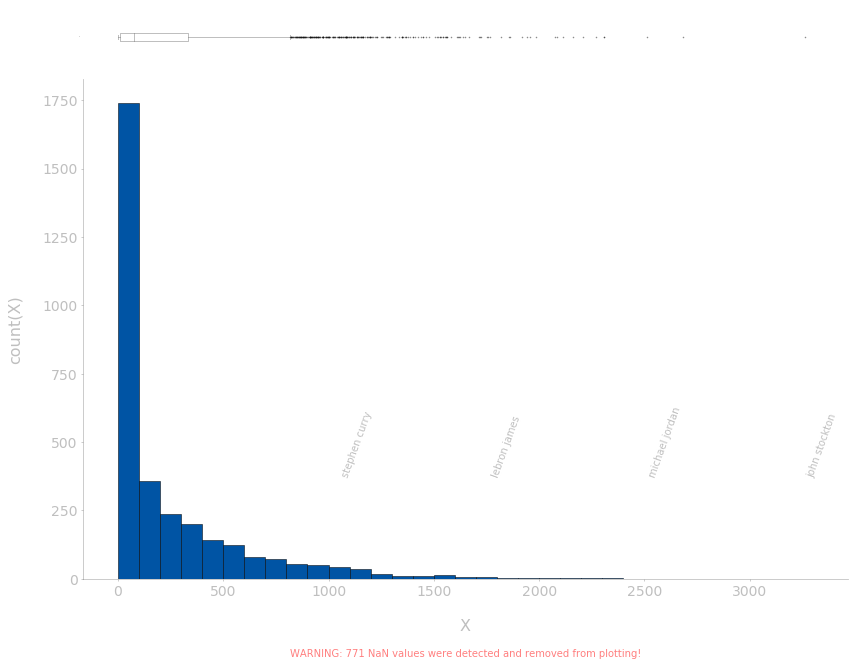

In [52]:
interesting_players = [
    'michael jordan', 
    'stephen curry',
    'lebron james']

credit = 'Source: basketball-reference.com | Author: Avid Basketball Fan | 2017'

# data = all_players_stats['totals'].xs('2000-01', level=1, drop_level=True)['3PA']

# plot_histogram(data=data, binwidth=None, xlabel='Career Points', ylabel='Number of Players', credit=credit)

# plot_histogram(data=data, color="#0054A4", credit=credit)

data = all_players_stats['totals'].xs('Career', level=1, drop_level=True)['STL']

ax_hist = plot_histogram(data=data, binwidth=None, annotations=interesting_players)

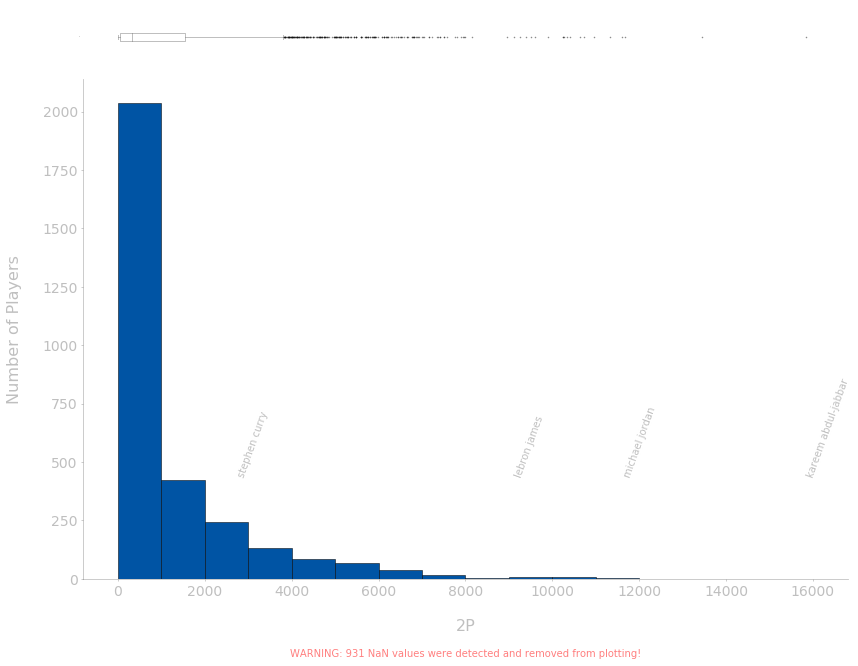

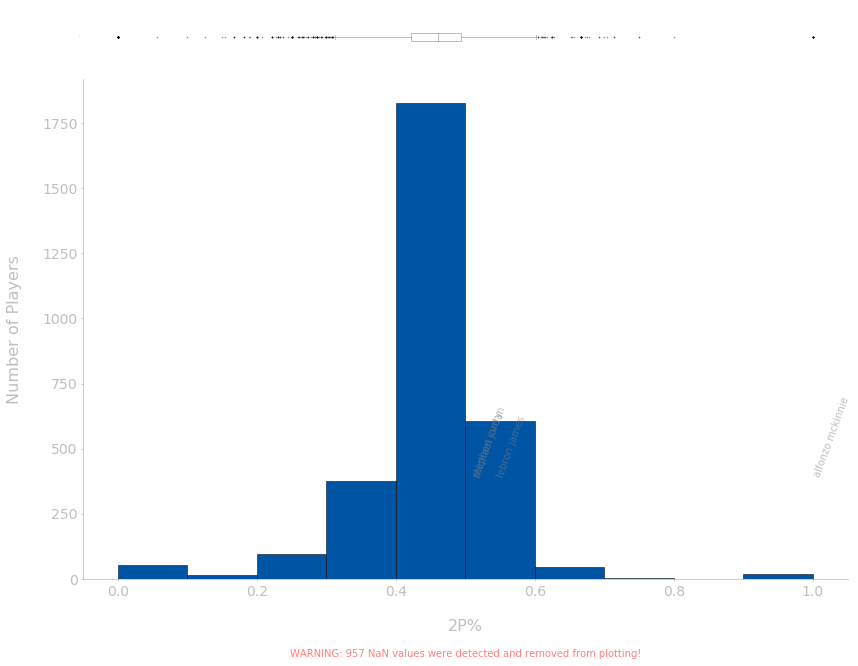

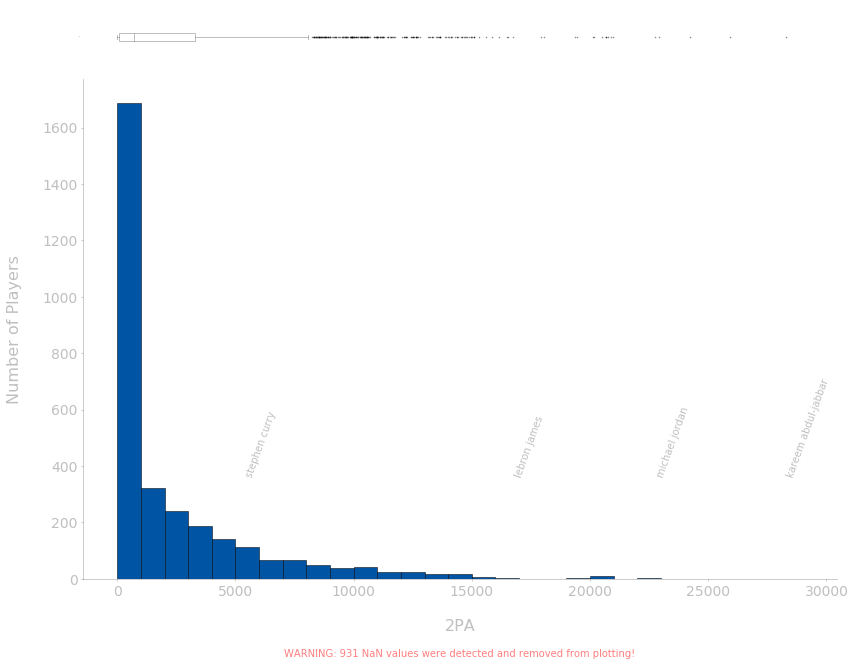

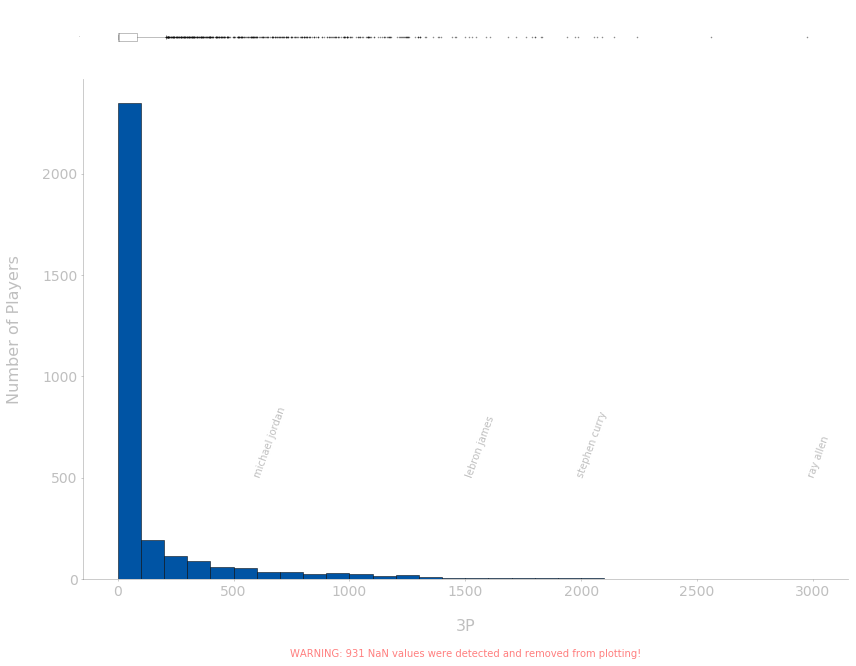

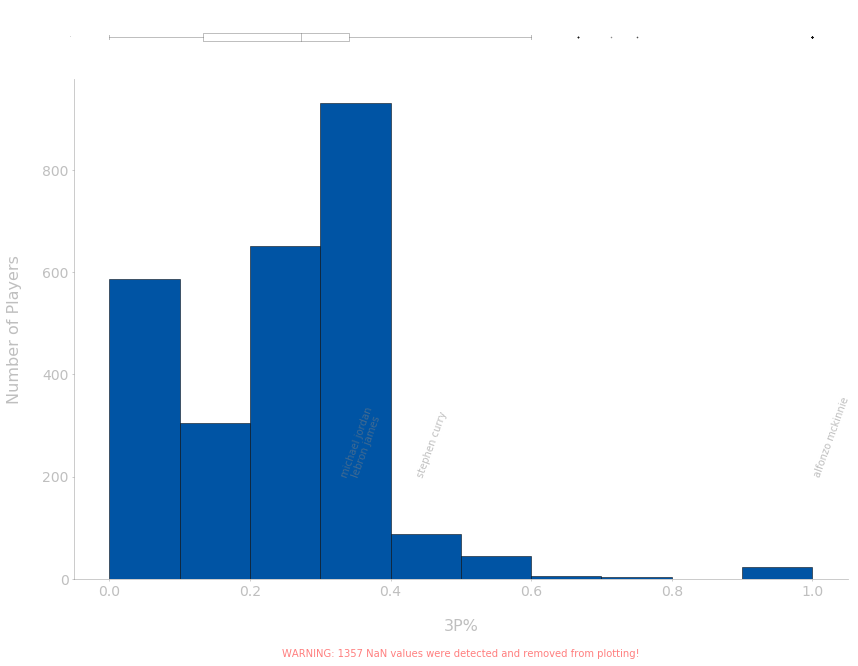

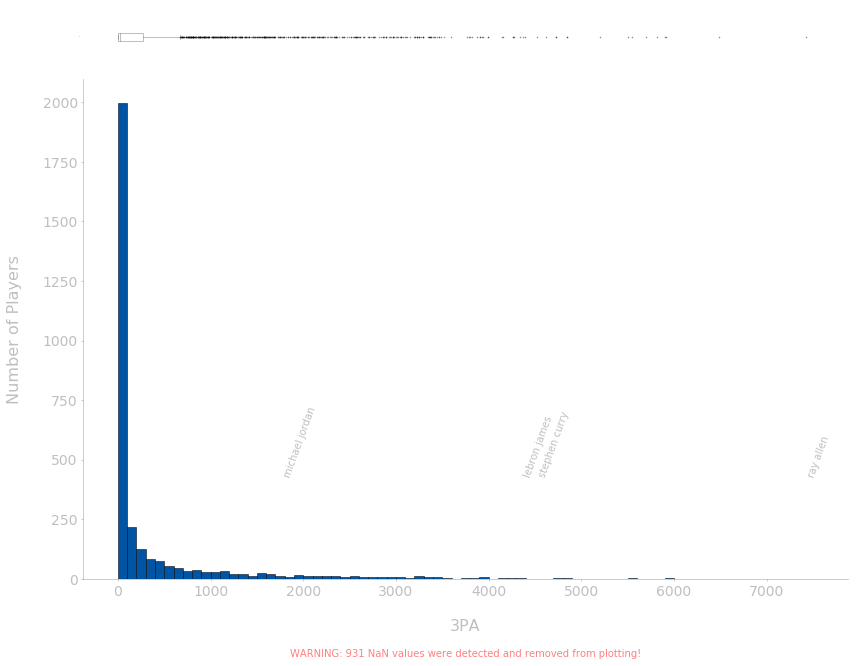

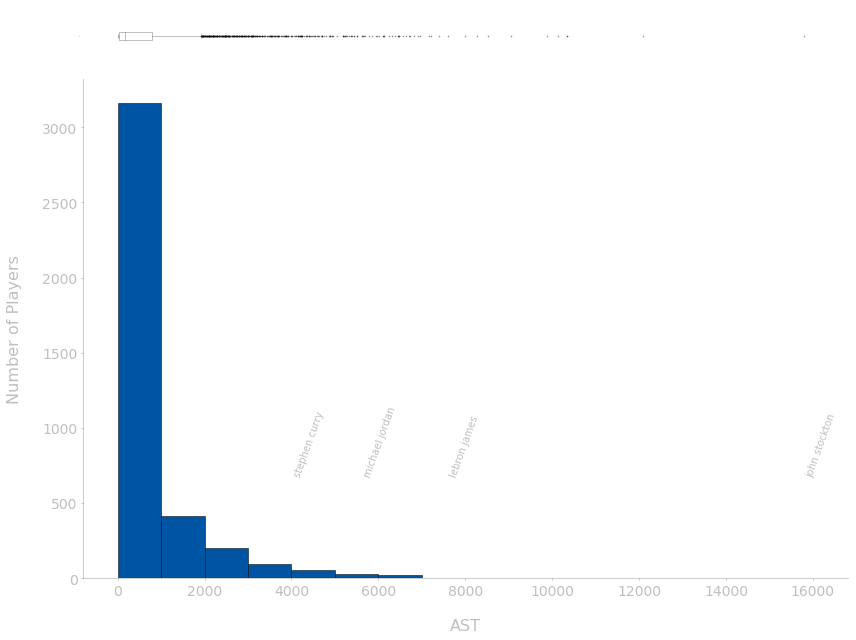

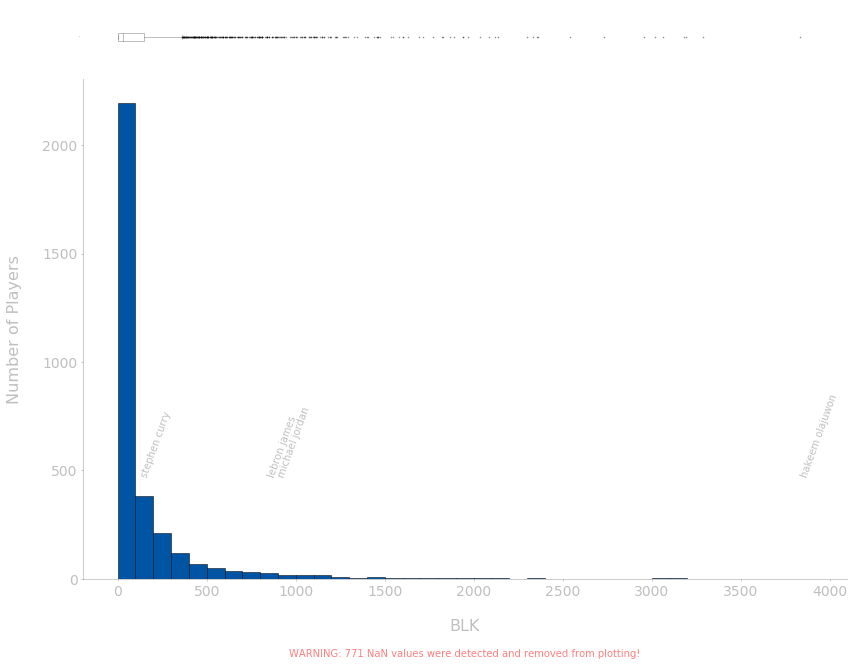

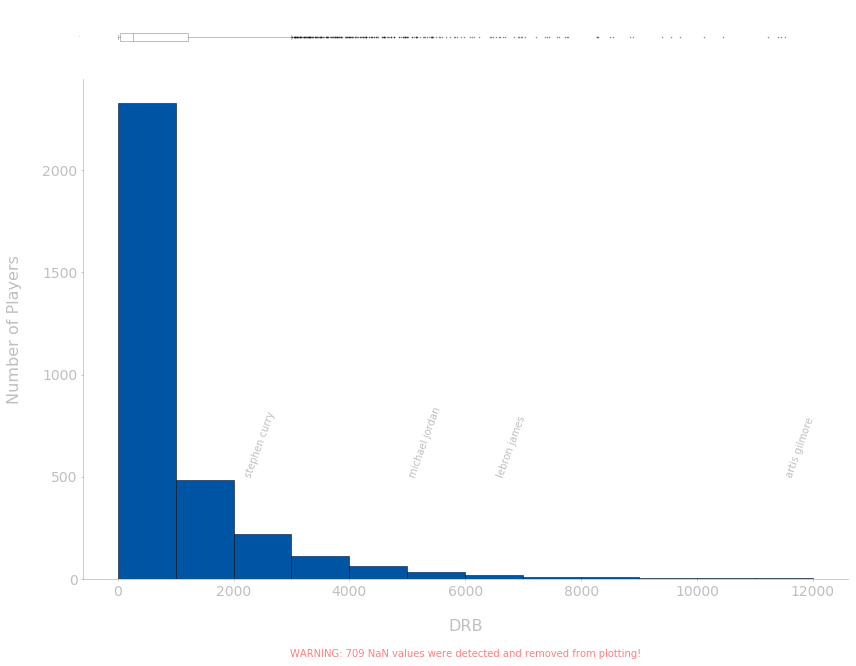

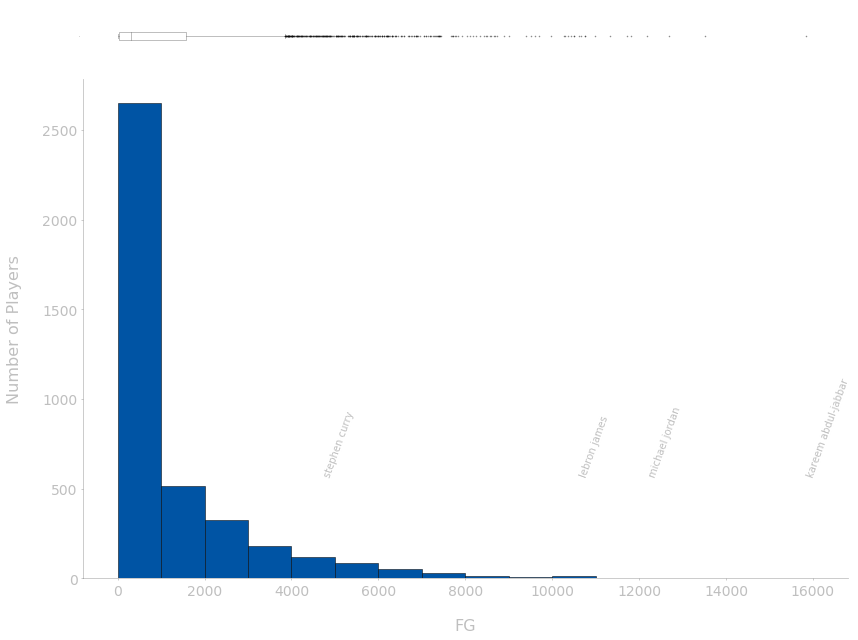

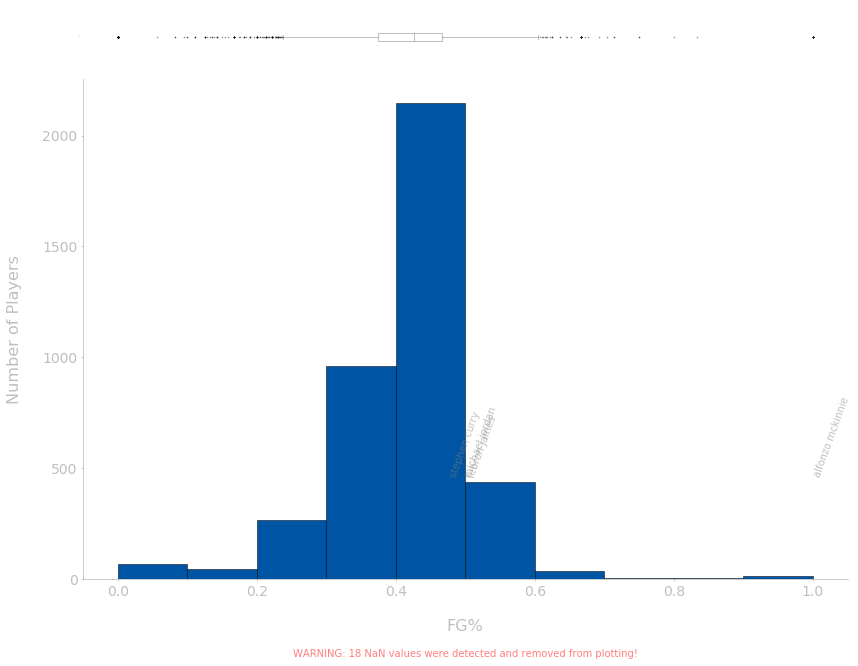

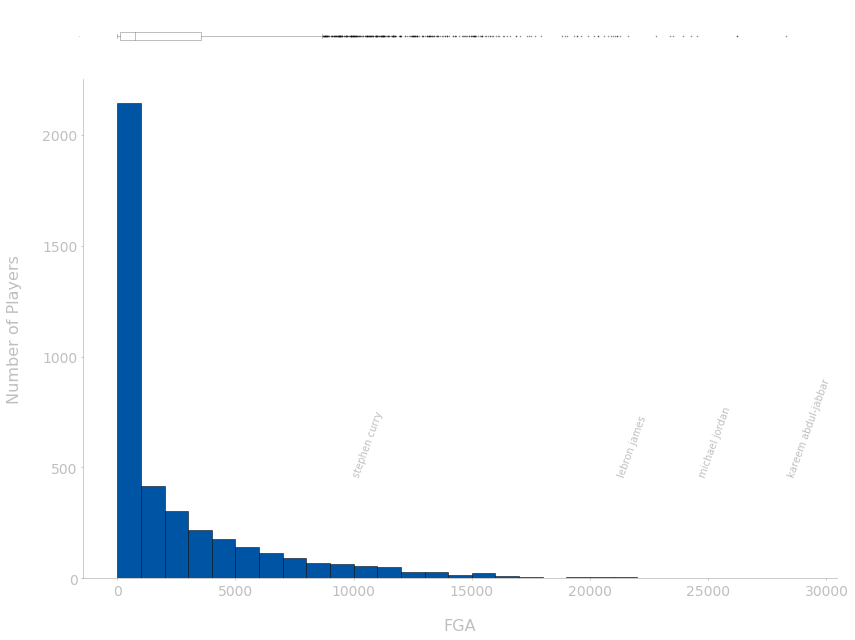

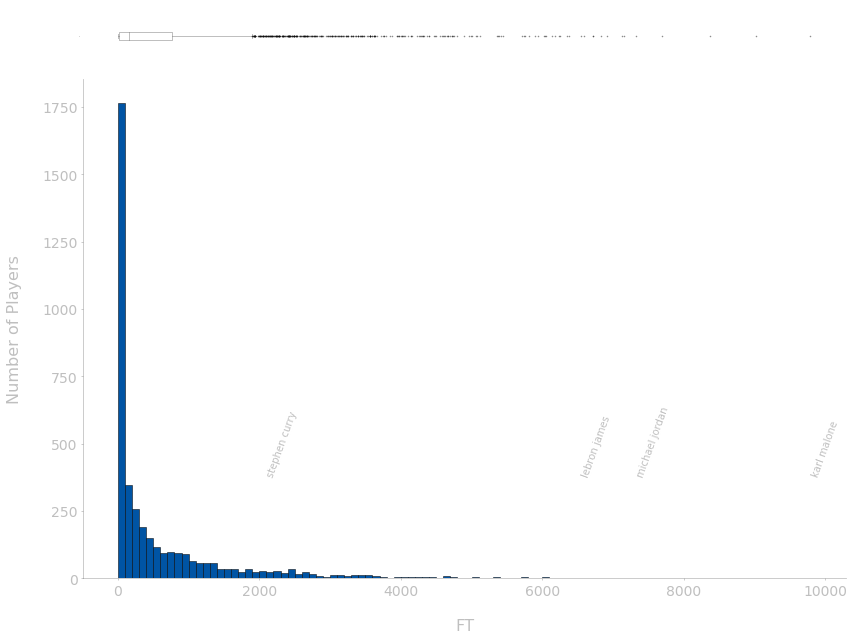

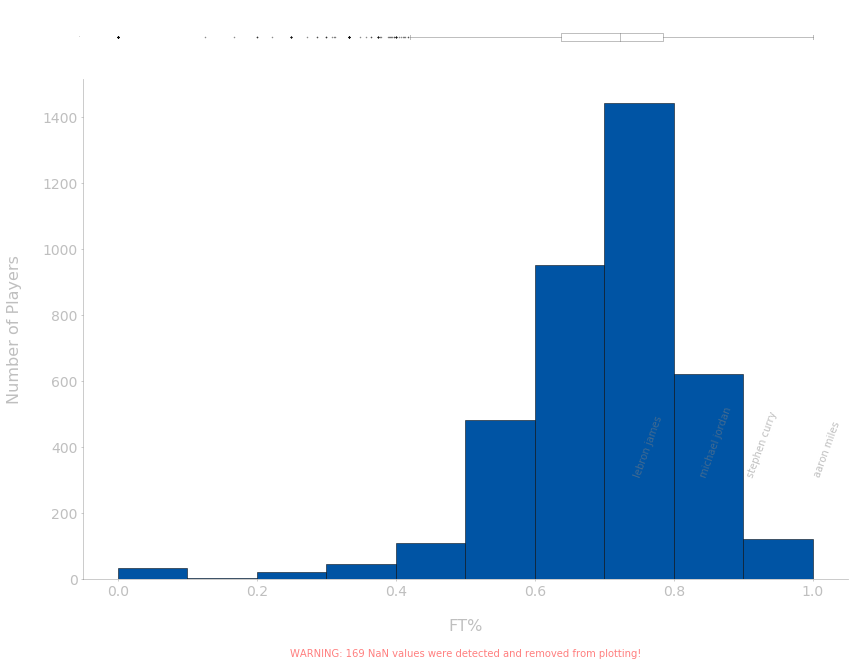

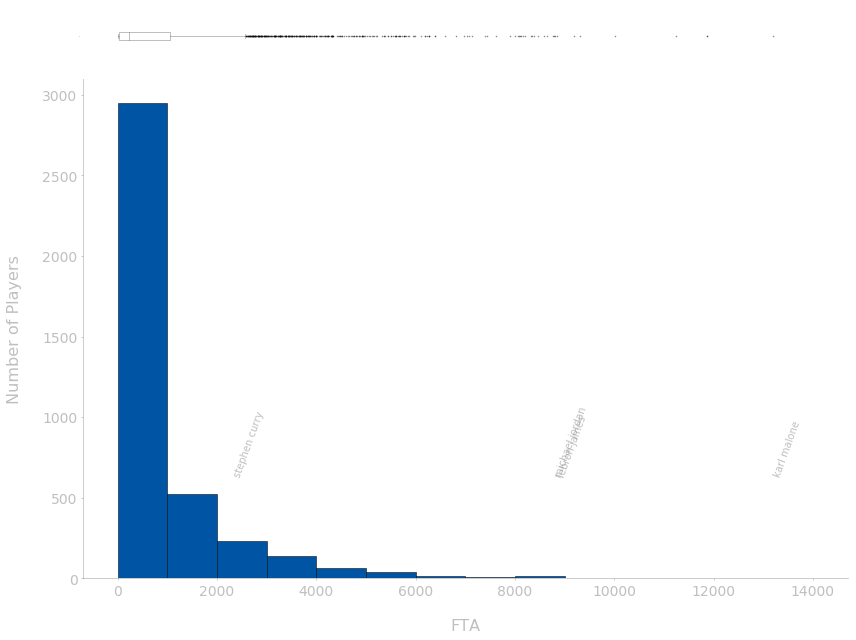

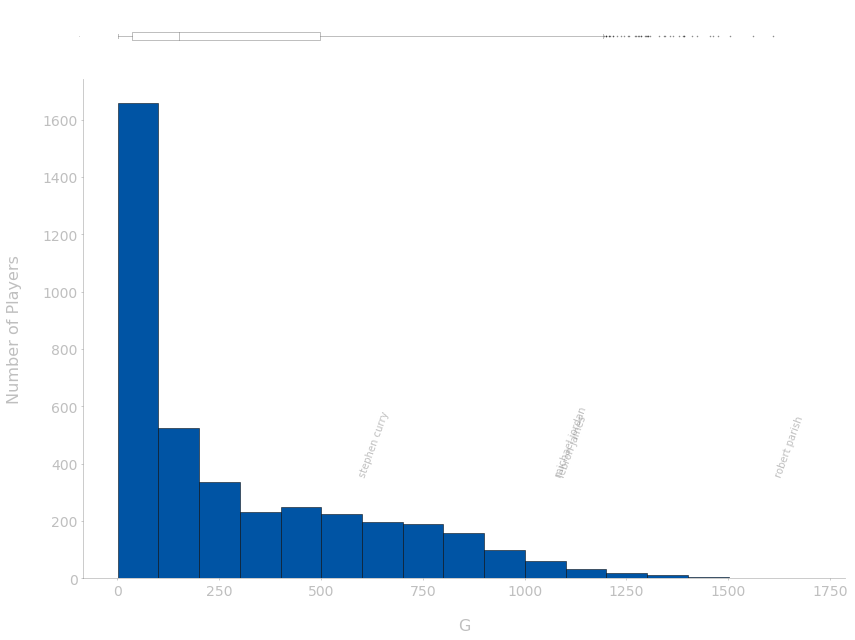

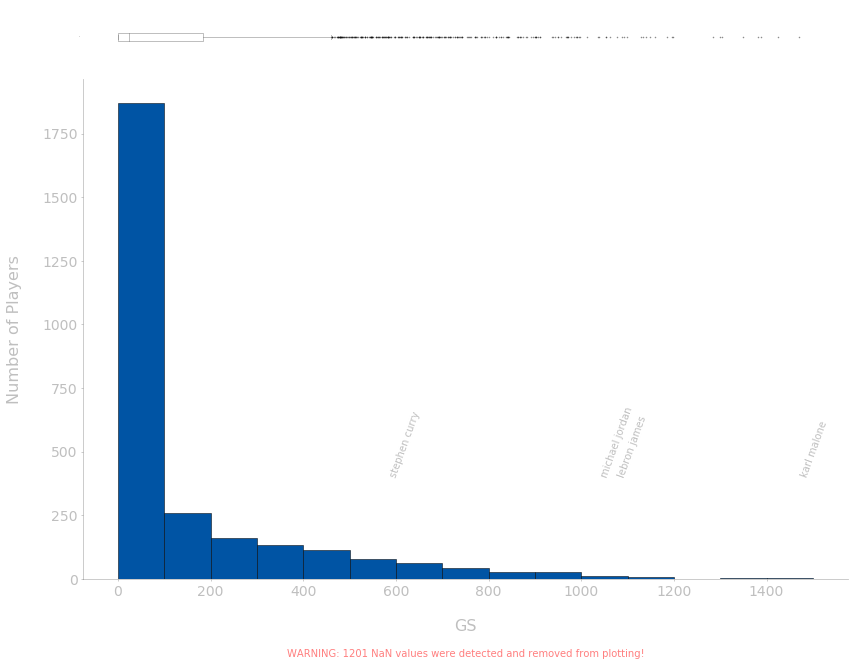

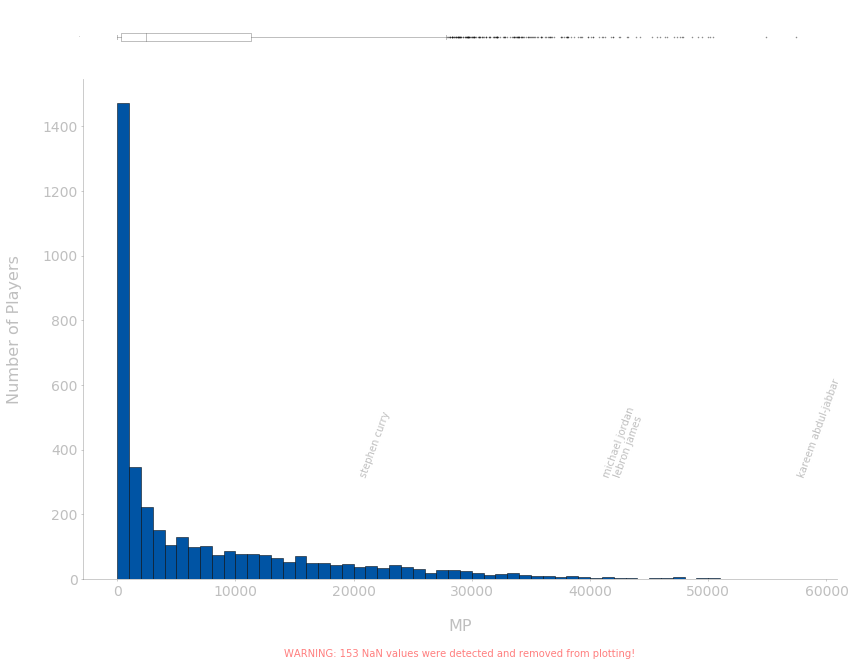

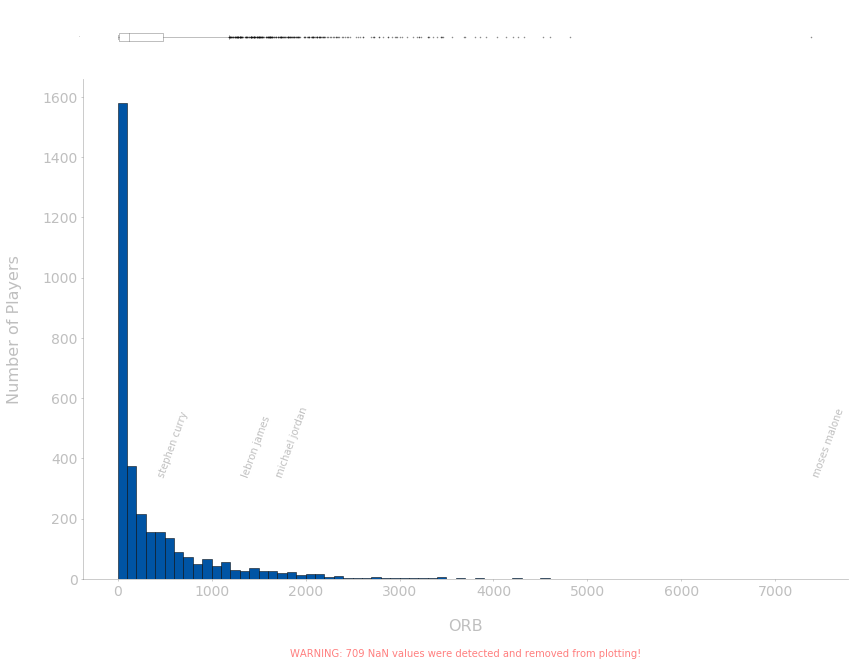

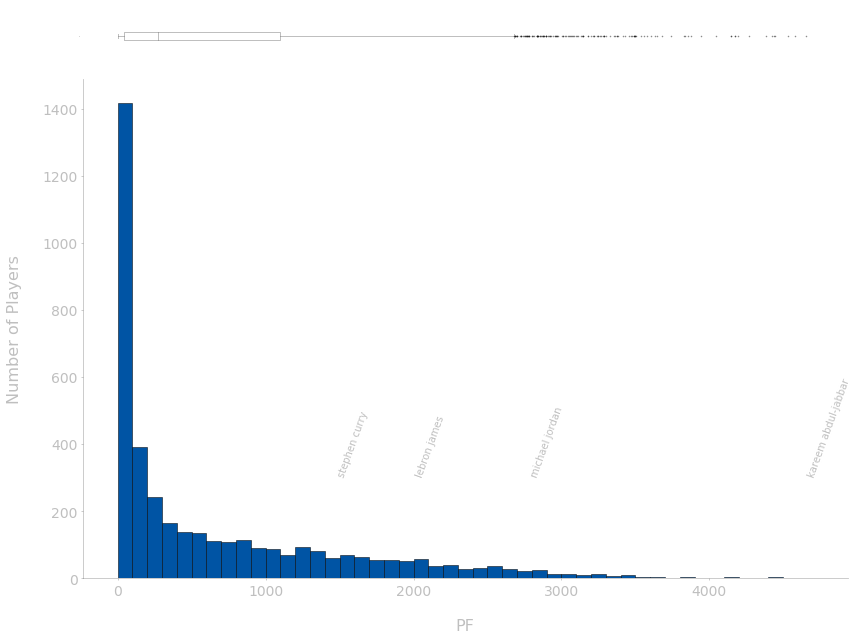

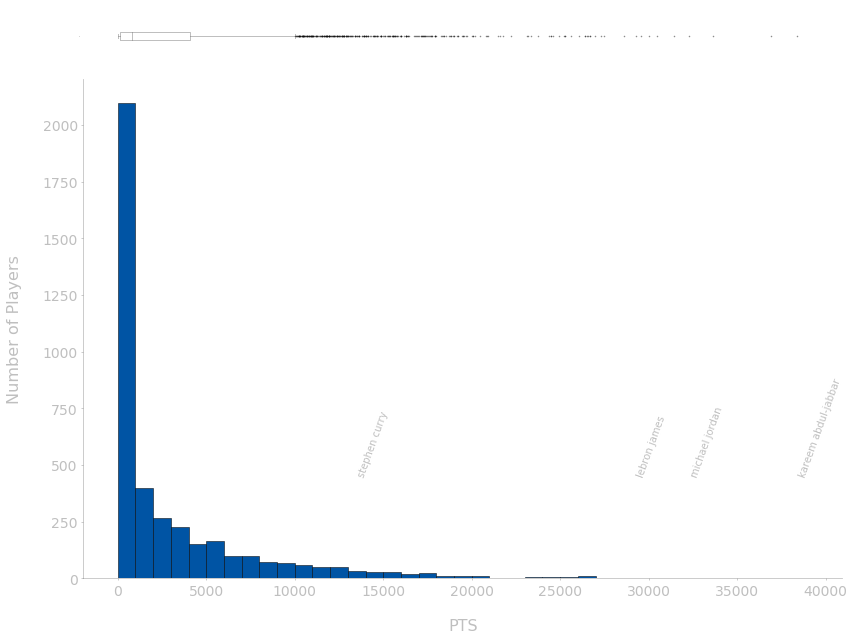

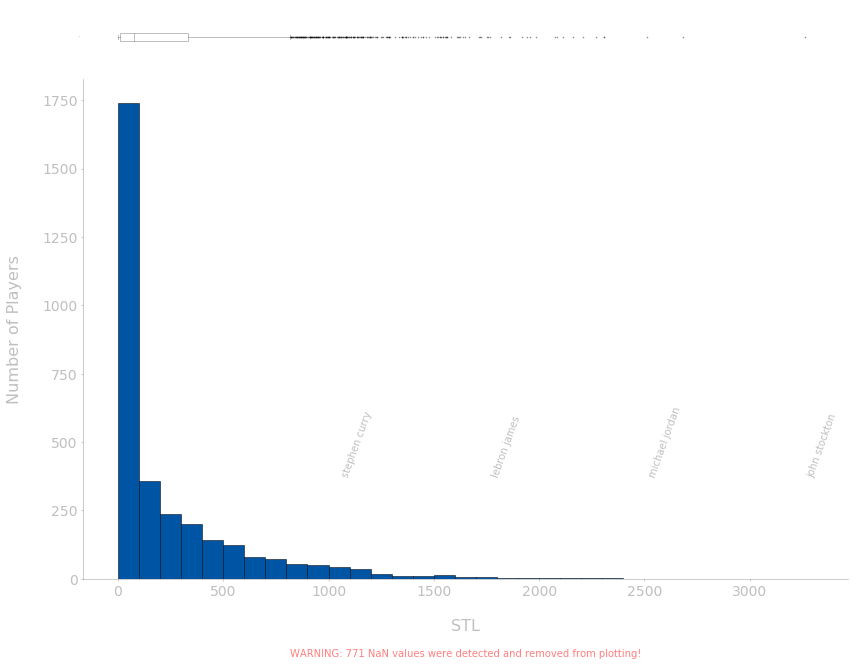

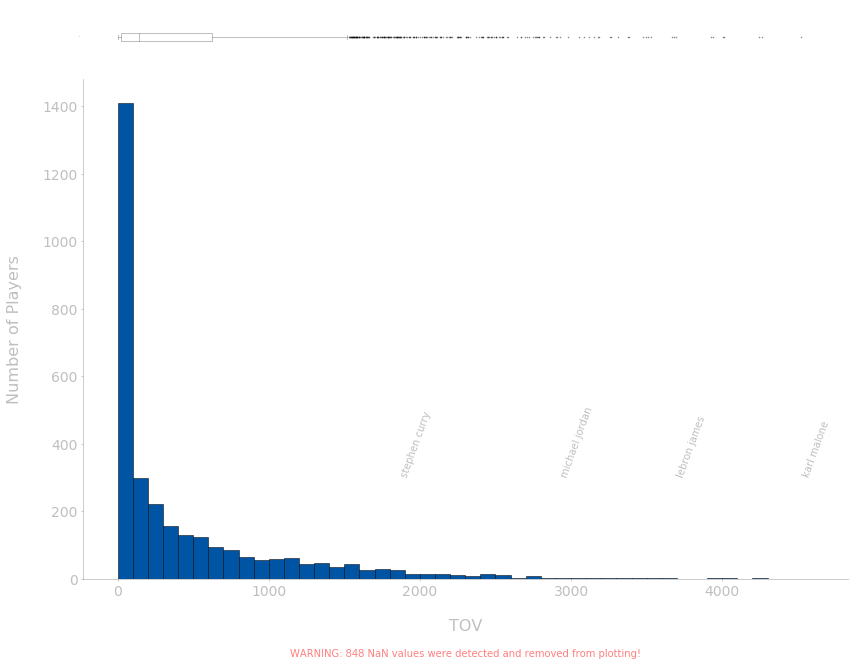

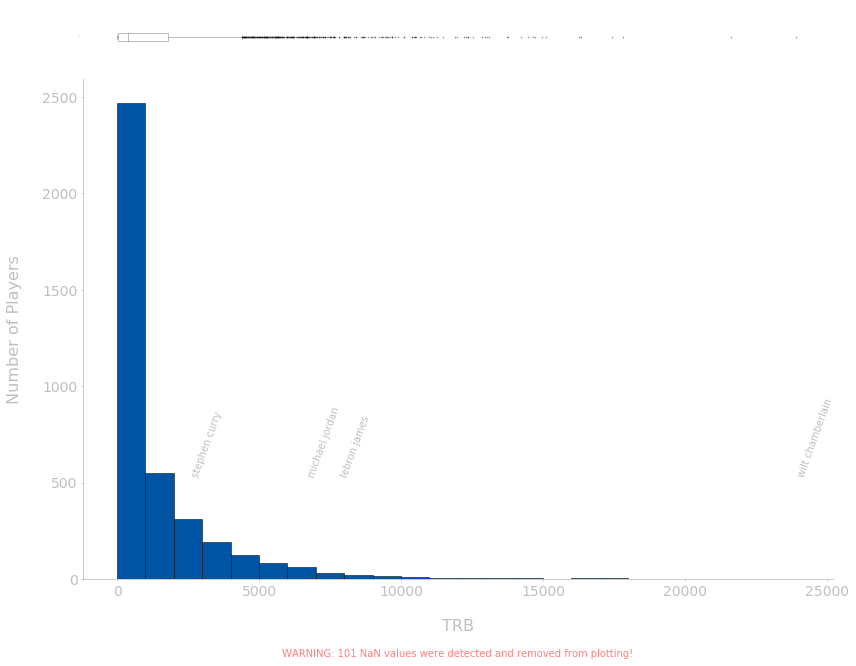

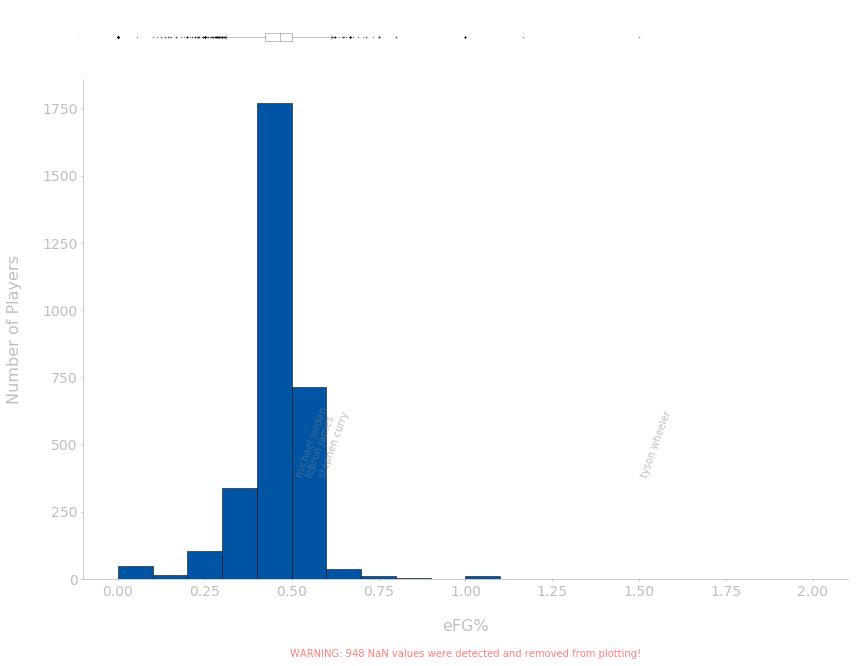

In [31]:
interesting_players = [
    'michael jordan', 
    'stephen curry',
    'lebron james']

stats = ['2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST', 'BLK', 'DRB',
       'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'G', 'GS', 'MP', 'ORB',
       'PF', 'PTS', 'STL', 'TOV', 'TRB', 'eFG%']

for stat in stats:
    
    data = all_players_stats['totals'].xs('Career', level=1, drop_level=True)[stat]

    plot_histogram(data=data, binwidth=None, ylabel='Number of Players', xlabel=stat, annotations=interesting_players)

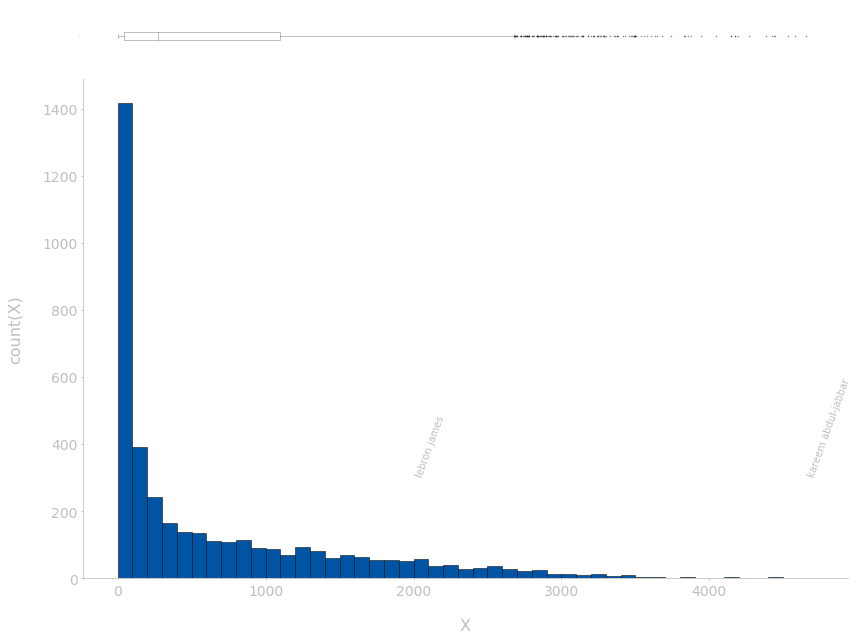

In [34]:
data = all_players_stats['totals'].xs('Career', level=1, drop_level=True)['PF']

ax_hist = plot_histogram(data=data, binwidth=None, annotations=['lebron james'])